In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Loading and Cleaning Data

In [2]:
text_column = ['reviews']
num_columns = ['track_popularity', 'discovery',
             'familiarity','hotttnesss','acousticness',
             'danceability','duration','energy','instrumentalness',
             'liveness','loudness','speechiness','tempo',
             'valence']
target_column = ['love']
data = pd.read_csv('playlist_with_reviews.csv', index_col=1)
data[text_column] = data[text_column[0]].apply(
            lambda x: unicode(x, errors='replace'))
data[text_column] = data[text_column[0]].apply(
            lambda x: x if len(x) > 100 else np.nan)
data = data[text_column + num_columns + target_column]
data.dropna(inplace=True)

print data.shape
data.columns

(93, 16)


Index([u'reviews', u'track_popularity', u'discovery', u'familiarity',
       u'hotttnesss', u'acousticness', u'danceability', u'duration', u'energy',
       u'instrumentalness', u'liveness', u'loudness', u'speechiness', u'tempo',
       u'valence', u'love'],
      dtype='object')

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_data = data[num_columns]
num_data = scaler.fit_transform(num_data)

text_data = data[text_column].reviews

#Training and Testing Split

In [4]:
from sklearn.cross_validation import StratifiedKFold
import random

train_idxs = np.array(random.sample(
    range(data.shape[0]), data.shape[0]/3))
mask = np.ones(len(data), dtype=bool)
mask[train_idxs] = False

target_train = np.array(data[target_column].ix[mask]) \
        .ravel()
target_test  = np.array(data[target_column].ix[~mask]) \
        .ravel()

num_train = num_data[mask]
num_test = num_data[~mask]

text_train = text_data[mask]
text_test = text_data[~mask]

print 'target data'
print type(target_train)
print target_train.shape
print target_test.shape
print 
print 'numerical data'
print type(num_train)
print num_train.shape
print num_test.shape
print
print 'text data'
print type(text_train)
print text_train.shape
print text_test.shape

target data
<type 'numpy.ndarray'>
(62,)
(31,)

numerical data
<type 'numpy.ndarray'>
(62, 14)
(31, 14)

text data
<class 'pandas.core.series.Series'>
(62,)
(31,)


#Setting Up Global Variables / Functions

In [5]:
from sklearn.cross_validation import KFold
from sklearn.metrics import classification_report

n_folds = 10
stack_train = np.zeros(target_train.shape[0])
stack_test = np.zeros(target_test.shape[0])

kf = list(KFold(target_train.shape[0], n_folds))

def train_model_and_predict(clf, train_data, test_data, verbose=True, thresh=0.5):
    stack_train_j = np.zeros(train_data.shape[0])
    stack_test_j = np.zeros((target_test.shape[0], n_folds))
    for i, (train, test) in enumerate(kf):
        print "Fold", i
        X_train, y_train = train_data[train], target_train[train]
        X_test, y_test = train_data[test], target_train[test]
        clf.fit(X_train, y_train)
        stack_train_j[test] = clf.predict_proba(X_test)[:,1]
        stack_test_j[:,i] = clf.predict_proba(test_data)[:,1]
    if verbose: 
        show_top_songs(stack_test_j.mean(1))
        print classification_report(target_train, (stack_train_j>thresh))
        
    return stack_train_j, stack_test_j.mean(1)

def show_top_songs(probas):
    top_songs = np.argsort(probas)[::-1]
    print data.ix[top_songs]['love']

#Text-Based Classifier (Naive Bayes)
###Simple Model

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


def create_ngram_model(params=None):
    tfidf_ngrams = TfidfVectorizer(ngram_range=(1,2),
                                   analyzer='word',
                                   binary=True)
    clf = MultinomialNB(alpha=0.01)
    pipeline =  Pipeline([('vect', tfidf_ngrams),
                          ('clf', clf)])
    if params:
        pipeline.set_params(**params)
    
    return pipeline


    
#Note: I overwrite stack_train and stack_test
NB = create_ngram_model()
stack_train, stack_test = train_model_and_predict(NB, text_train, text_test)
print stack_train.shape
print stack_test.shape



Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
track_name
Loud Pipes                                            1
Fire At The Pageant                                   1
Falling Man                                           1
On the Water                                          1
The Great Gig In The Sky - 2011 Remastered Version    1
Here Comes Your Man                                   1
Champagne Coast                                       0
So Many Details                                       0
Said So What                                          0
Last Night At The Jetty                               1
Hell is chrome                                        1
Amen                                                  1
Lonesome Dreams                                       1
Since I've Been Loving You - Live                     1
Siberian Breaks                                       1
There, There                                          1
Good Vibrations - 2001 

###Complex NB

In [7]:
import csv
import collections
import sys
# sys.setdefaultencoding("utf-8")

def load_sent_word_net(swn_file='SentiWordNet_3.0.0_20130122.txt'):
    sent_scores = collections.defaultdict(list)
    with open(swn_file) as csvfile:
        reader = csv.reader(csvfile, delimiter='\t', quotechar='"')
        for line in reader:
            if line[0].startswith("#"): continue
            if len(line) == 1: continue
            
            POS, ID, PosScore, NegScore, SynsetTerms, Gloss = line
            if len(POS) == 0 or len(ID) == 0: continue
            
            for term in SynsetTerms.split(" "):
                #drop #number at end of every term
                term = term.replace("-"," ").replace("_"," ")
                key = '%s/%s'%(POS, term.split("#")[0])
                sent_scores[key].append((float(PosScore),float(NegScore)))
        for key, value in sent_scores.items():
            sent_scores[key] = np.mean(value, axis=0)
        
        return sent_scores

sent_word_net = load_sent_word_net()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.base import BaseEstimator
from sklearn.naive_bayes import MultinomialNB
import nltk
import re

class LinguisticVectorizer(BaseEstimator):
    def get_feature_names(self):
        return np.array(['sent_neut', 'sent_pos', 'sent_neg',
                         'nouns', 'adjectives', 'verbs', 'adverbs',
                         'allcaps', 'exclamation', 'question'])

    def fit(self, documents, y=None):
        return self
    
    def _get_sentiments(self, d):
        sent = tuple(nltk.word_tokenize(d))
        tagged = nltk.pos_tag(sent)

        pos_vals = []
        neg_vals = []

        nouns = 0.
        adjectives = 0.
        verbs = 0.
        adverbs = 0.

        for w, t in tagged:
            p, n = 0, 0
            sent_pos_type = None
            if t.startswith("NN"):
                sent_pos_type = "n"
                nouns += 1
            elif t.startswith("JJ"):
                sent_pos_type = "a"
                adjectives += 1
            elif t.startswith("VB"):
                sent_pos_type = "v"
                verbs += 1
            elif t.startswith("RB"):
                sent_pos_type = "r"
                adverbs += 1

            if sent_pos_type is not None:
                sent_word = "%s/%s" % (sent_pos_type, w)

                if sent_word in sent_word_net:
                    p, n = sent_word_net[sent_word]

            pos_vals.append(p)
            neg_vals.append(n)

        l = len(sent)
        avg_pos_val = np.mean(pos_vals)
        avg_neg_val = np.mean(neg_vals)

        return [1 - avg_pos_val - avg_neg_val, avg_pos_val, avg_neg_val,
                nouns / l, adjectives / l, verbs / l, adverbs / l]

    def transform(self, documents):
        obj_val, pos_val, neg_val, nouns, adjectives, verbs, adverbs = np.array(
            [self._get_sentiments(d) for d in documents]).T

        allcaps = []
        exclamation = []
        question = []

        for d in documents:
            allcaps.append(
                np.sum([t.isupper() for t in d.split() if len(t) > 2]))

            exclamation.append(d.count("!"))
            question.append(d.count("?"))

        result = np.array(
            [obj_val, pos_val, neg_val, nouns, adjectives, verbs, adverbs, allcaps,
             exclamation, question]).T

        return result

re_repl = {
    r"\br\b": "are",
    r"\bu\b": "you",
    r"\bhaha\b": "ha",
    r"\bhahaha\b": "ha",
    r"\bdon't\b": "do not",
    r"\bdoesn't\b": "does not",
    r"\bdidn't\b": "did not",
    r"\bhasn't\b": "has not",
    r"\bhaven't\b": "have not",
    r"\bhadn't\b": "had not",
    r"\bwon't\b": "will not",
    r"\bwouldn't\b": "would not",
    r"\bcan't\b": "can not",
    r"\bcannot\b": "can not",
}

def create_union_model(params=None):
    def preprocessor(doc):
        doc = doc.lower()

        for r, repl in re_repl.items():
            doc = re.sub(r, repl, doc)

        return doc.replace("-", " ").replace("_", " ")

    tfidf_ngrams = TfidfVectorizer(preprocessor=preprocessor,
                                   analyzer="word",
                                   decode_error='ignore')
    ling_stats = LinguisticVectorizer()
    all_features = FeatureUnion(
        [('ling', ling_stats), ('tfidf', tfidf_ngrams)])
#     all_features = FeatureUnion([('tfidf', tfidf_ngrams)])
#     all_features = FeatureUnion([('ling', ling_stats)])
    clf = MultinomialNB()
    pipeline = Pipeline([('all', all_features), ('clf', clf)])

    if params:
        pipeline.set_params(**params)

    return pipeline

unionNB = create_union_model()
unionNB_train, unionNB_test = train_model_and_predict(unionNB, text_train, text_test)
print unionNB_train.shape
print unionNB_test.shape

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
track_name
There, There                                          1
Seabeast                                              1
Ffunny Ffrends                                        0
Feet and Bones                                        1
Elephant Gun                                          0
Dodge the Dodo                                        1
On the Water                                          1
Since I've Been Loving You - Live                     1
Siberian Breaks                                       1
Loud Pipes                                            1
Falling Man                                           1
Last Night At The Jetty                               1
Here Comes Your Man                                   1
The Great Gig In The Sky - 2011 Remastered Version    1
Hell is chrome                                        1
Champagne Coast                                       0
Silent Shout           

/Users/davidgoldberg/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [8]:
stack_train = np.vstack((stack_train, unionNB_train))
stack_test = np.vstack((stack_test, unionNB_test))

#Numerical Classifiers
###Tuning the SVM

In [9]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
def grid_model_svm(cv=5):
    param_grid = dict(gamma=np.logspace(-2, 10, 13), 
                      C=np.logspace(-9, 3, 13),
                      kernel=['linear','rbf','sigmoid'])
    grid = GridSearchCV(SVC(probability=True), 
                        param_grid=param_grid,
                        scoring='f1',
                        cv=cv,
                        verbose=1)
    return grid

###Training the Model

In [10]:
from sklearn.ensemble import RandomForestClassifier, \
                             ExtraTreesClassifier, \
                             GradientBoostingClassifier, \
                             AdaBoostClassifier, \
                             BaggingClassifier
from sklearn.linear_model import LogisticRegressionCV

clfs = [
    BaggingClassifier(n_estimators=100),
    AdaBoostClassifier(n_estimators=100, learning_rate=0.05),
    RandomForestClassifier(n_estimators=100),
    ExtraTreesClassifier(n_estimators=100),
    GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, subsample=0.5),
    grid_model_svm(),
    LogisticRegressionCV(cv=10, scoring='f1')
]
clf_names = ['Bagging','AdaBoost','Random Forest', 'Extra Tree', \
             'Gradient Boost', 'SVC','Logit']

for j, clf in enumerate(clfs):
    print j, clf
    train, test = train_model_and_predict(clf, num_train, num_test)
    stack_train = np.vstack((stack_train, train))
    stack_test = np.vstack((stack_test, test))

stack_train = stack_train.T
stack_test = stack_test.T

print stack_train.shape
print stack_test.shape

0 BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
         verbose=0)
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
track_name
Here Comes Your Man                                   1
Eventually                                            1
Seabeast                                              1
Ffunny Ffrends                                        0
Champagne Coast                                       0
Feet and Bones                                        1
Last Night At The Jetty                               1
Hell is chrome                                        1
The Great Gig In The Sky - 2011 Remastered Version    1
Loud Pipes                                            1
Falling Man                                           1
On the Water                                          1
Said So What               

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 450 jobs       | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 800 jobs       | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done 1250 jobs       | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done 1800 jobs       | elapsed:    6.8s
[Parallel(n_jobs=1)]: Done 2450 jobs       | elapsed:  2.0min



             precision    recall  f1-score   support

          0       0.26      0.25      0.26        24
          1       0.54      0.55      0.55        38

avg / total       0.43      0.44      0.43        62

5 GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'kernel': ['linear', 'rbf', 'sigmoid'], 'C': array([  1.00000e-09,   1.00000e-08,   1.00000e-07,   1.00000e-06,
         1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03]), 'gamma': array([  ...0000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scori

[Parallel(n_jobs=1)]: Done 2535 out of 2535 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 450 jobs       | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done 800 jobs       | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done 1250 jobs       | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 1800 jobs       | elapsed:    7.5s
/Users/davidgoldberg/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done 2450 jobs       | elapsed:  1.5min


 1
Fitting 5 folds for each of 507 candidates, totalling 2535 fits
Fold

[Parallel(n_jobs=1)]: Done 2535 out of 2535 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 450 jobs       | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 800 jobs       | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done 1250 jobs       | elapsed:    4.3s
[Parallel(n_jobs=1)]: Done 1800 jobs       | elapsed:    6.6s
[Parallel(n_jobs=1)]: Done 2450 jobs       | elapsed:  2.0min


 2
Fitting 5 folds for each of 507 candidates, totalling 2535 fits
Fold

[Parallel(n_jobs=1)]: Done 2535 out of 2535 | elapsed:  3.2min finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 450 jobs       | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done 800 jobs       | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done 1250 jobs       | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 1800 jobs       | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done 2450 jobs       | elapsed:  1.8min


 3
Fitting 5 folds for each of 507 candidates, totalling 2535 fits
Fold

[Parallel(n_jobs=1)]: Done 2535 out of 2535 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 450 jobs       | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 800 jobs       | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done 1250 jobs       | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done 1800 jobs       | elapsed:    6.9s
[Parallel(n_jobs=1)]: Done 2450 jobs       | elapsed:  1.8min


 4
Fitting 5 folds for each of 507 candidates, totalling 2535 fits
Fold

[Parallel(n_jobs=1)]: Done 2535 out of 2535 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 450 jobs       | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done 800 jobs       | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done 1250 jobs       | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done 1800 jobs       | elapsed:    7.1s
[Parallel(n_jobs=1)]: Done 2450 jobs       | elapsed:  1.4min


 5
Fitting 5 folds for each of 507 candidates, totalling 2535 fits
Fold

[Parallel(n_jobs=1)]: Done 2535 out of 2535 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 450 jobs       | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done 800 jobs       | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 1250 jobs       | elapsed:    5.4s
[Parallel(n_jobs=1)]: Done 1800 jobs       | elapsed:    7.8s
[Parallel(n_jobs=1)]: Done 2450 jobs       | elapsed:  2.8min


 6
Fitting 5 folds for each of 507 candidates, totalling 2535 fits
Fold

[Parallel(n_jobs=1)]: Done 2535 out of 2535 | elapsed:  4.2min finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 450 jobs       | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done 800 jobs       | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 1250 jobs       | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done 1800 jobs       | elapsed:   10.9s
[Parallel(n_jobs=1)]: Done 2450 jobs       | elapsed:  2.7min


 7
Fitting 5 folds for each of 507 candidates, totalling 2535 fits
Fold

[Parallel(n_jobs=1)]: Done 2535 out of 2535 | elapsed:  5.2min finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 450 jobs       | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done 800 jobs       | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 1250 jobs       | elapsed:    8.0s
[Parallel(n_jobs=1)]: Done 1800 jobs       | elapsed:   10.6s
[Parallel(n_jobs=1)]: Done 2450 jobs       | elapsed:  1.9min


 8
Fitting 5 folds for each of 507 candidates, totalling 2535 fits
Fold

[Parallel(n_jobs=1)]: Done 2535 out of 2535 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 450 jobs       | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 800 jobs       | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done 1250 jobs       | elapsed:    4.7s
[Parallel(n_jobs=1)]: Done 1800 jobs       | elapsed:    6.9s
[Parallel(n_jobs=1)]: Done 2450 jobs       | elapsed:  3.2min


 9
Fitting 5 folds for each of 507 candidates, totalling 2535 fits
track_name
Just From Chevron                                     1
Trouble                                               0
Lonesome Dreams                                       1
You Are All I See                                     0
Elephant Gun                                          0
So Many Details                                       0
The Funeral                                           1
Fire At The Pageant                                   1
Champagne Coast                                       0
Good Vibrations - 2001 - Remaster                     1
Feet and Bones                                        1
Amen                                                  1
There, There                                          1
Sleeping Lessons - The RAC Mix                        0
Since I've Been Loving You - Live                     1
Silent Shout                                          1
Last Night At The Jetty   

[Parallel(n_jobs=1)]: Done 2535 out of 2535 | elapsed:  4.3min finished


#Stacked Regression

In [11]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(stack_train, target_train)
probas = clf.predict_proba(stack_test)[:,1]

#Results

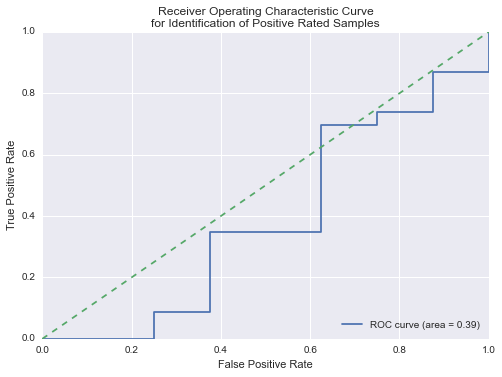

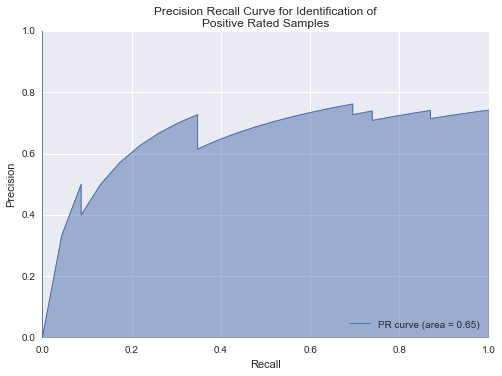

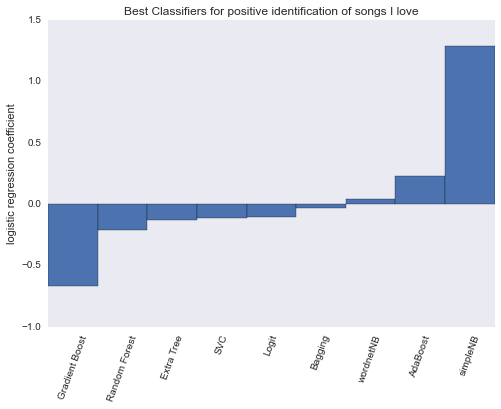

In [12]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

def plot_roc_curve(y_test, y_probas):
    fpr, tpr, _ = roc_curve(y_test, y_probas)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)'%roc_auc)
    plt.plot([0.0,1.0],[0.0,1.0], linestyle='--')
    plt.title('Receiver Operating Characteristic Curve \n'+\
              'for Identification of Positive Rated Samples')
    plt.legend(loc='lower right')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

def plot_pr_curve(y_test, y_probas):
    precision, recall, thresholds = precision_recall_curve(
            y_test, y_probas)
    pr_auc = auc(recall, precision)
    plt.figure()
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.grid(True)
    plt.fill_between(recall, precision, alpha=0.5)
    plt.plot(recall, precision, lw=1, label='PR curve (area = %0.2f)'%pr_auc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower right')
    plt.title('Precision Recall Curve for Identification of\n'+\
              'Positive Rated Samples')

def plot_feature_importance(feature_names, coef_, name=''):
    plt.figure()

    coef = coef_.ravel()
    
    inds = np.argsort(coef)
    feature_names = np.array(feature_names)
    feature_names = feature_names[inds]
    coef = coef[inds]

    xpos = np.array(list(range(len(coef))))
    plt.bar(xpos, coef, width=1)
    plt.grid(False)
    
    plt.title('Best Classifiers for positive identification of songs I love')
    ax = plt.gca()
    ax.set_xticks(np.arange(len(coef))+0.5)
    ax.set_xticklabels(feature_names, rotation=70, ha='center')
    ax.set_ylabel('logistic regression coefficient')   
plot_roc_curve(target_test, probas)
plot_pr_curve(target_test, probas)
feature_names = ['simpleNB','wordnetNB'] + clf_names
plot_feature_importance(feature_names, clf.coef_)

In [14]:
show_top_songs(probas)

track_name
Lonesome Dreams                                       1
Just From Chevron                                     1
So Many Details                                       0
Said So What                                          0
Fire At The Pageant                                   1
Trouble                                               0
The Funeral                                           1
The Great Gig In The Sky - 2011 Remastered Version    1
Amen                                                  1
Siberian Breaks                                       1
Falling Man                                           1
On the Water                                          1
There, There                                          1
Loud Pipes                                            1
Since I've Been Loving You - Live                     1
Hell is chrome                                        1
Champagne Coast                                       0
Here Comes Your Man                  

In [13]:
len(feature_names)
len(clf.coef_)

1

Thanks to Emanuele for his [kaggle_pbr](https://github.com/emanuele/kaggle_pbr/blob/master/blend.py)  script